# Laplace Transform, visualized

The goal of this is to visualize how the Laplace Transform works:

$$\mathscr{L}\{f(t)\}=F(s)$$

To do this, we need to look at the definition of the inverse Laplace Transform, specifically the one called the [Bromwich Integral](http://mathworld.wolfram.com/BromwichIntegral.html):

$$f(t) = \mathscr{L}^{-1}\{F(s)\}=\frac{1}{2\pi j}\int^{c+j\infty}_{c-j\infty} F(s)e^{st}\mathrm{d}s$$

While pretty, it's not so nice to work with, so let's make the substition:

$$s := c+jr$$

so that our new limits are just $\infty$ to $-\infty$, and $\mathrm{d}s/\mathrm{d}r = j$ giving:

$$f(t) = \mathscr{L}^{-1}\{F(s)\}=\frac{1}{2\pi j}\int^{\infty}_{-\infty} F(c+jr)e^{(c+jr)t}j\mathrm{d}r$$

$$= \frac{1}{2\pi}\int^{\infty}_{-\infty} F(c+jr)e^{(c+jr)t}\mathrm{d}r$$

Which we will now approximate as:

$$\approx \frac{1}{2\pi}\sum^{n}_{i=-n} F(c+jr_i)e^{(c+jr_i)t}\Delta r_i$$

Where we are summing between some range, in some variable step size $\Delta r$.

Note that each step is actually a complex number with a non-zero imaginary component, **however** I have observed that if I sum both the positive and negative parts of s, then the imaginary parts cancel out, giving a real function that I can plot.  I don't know if this is always true, but I do think it is so.

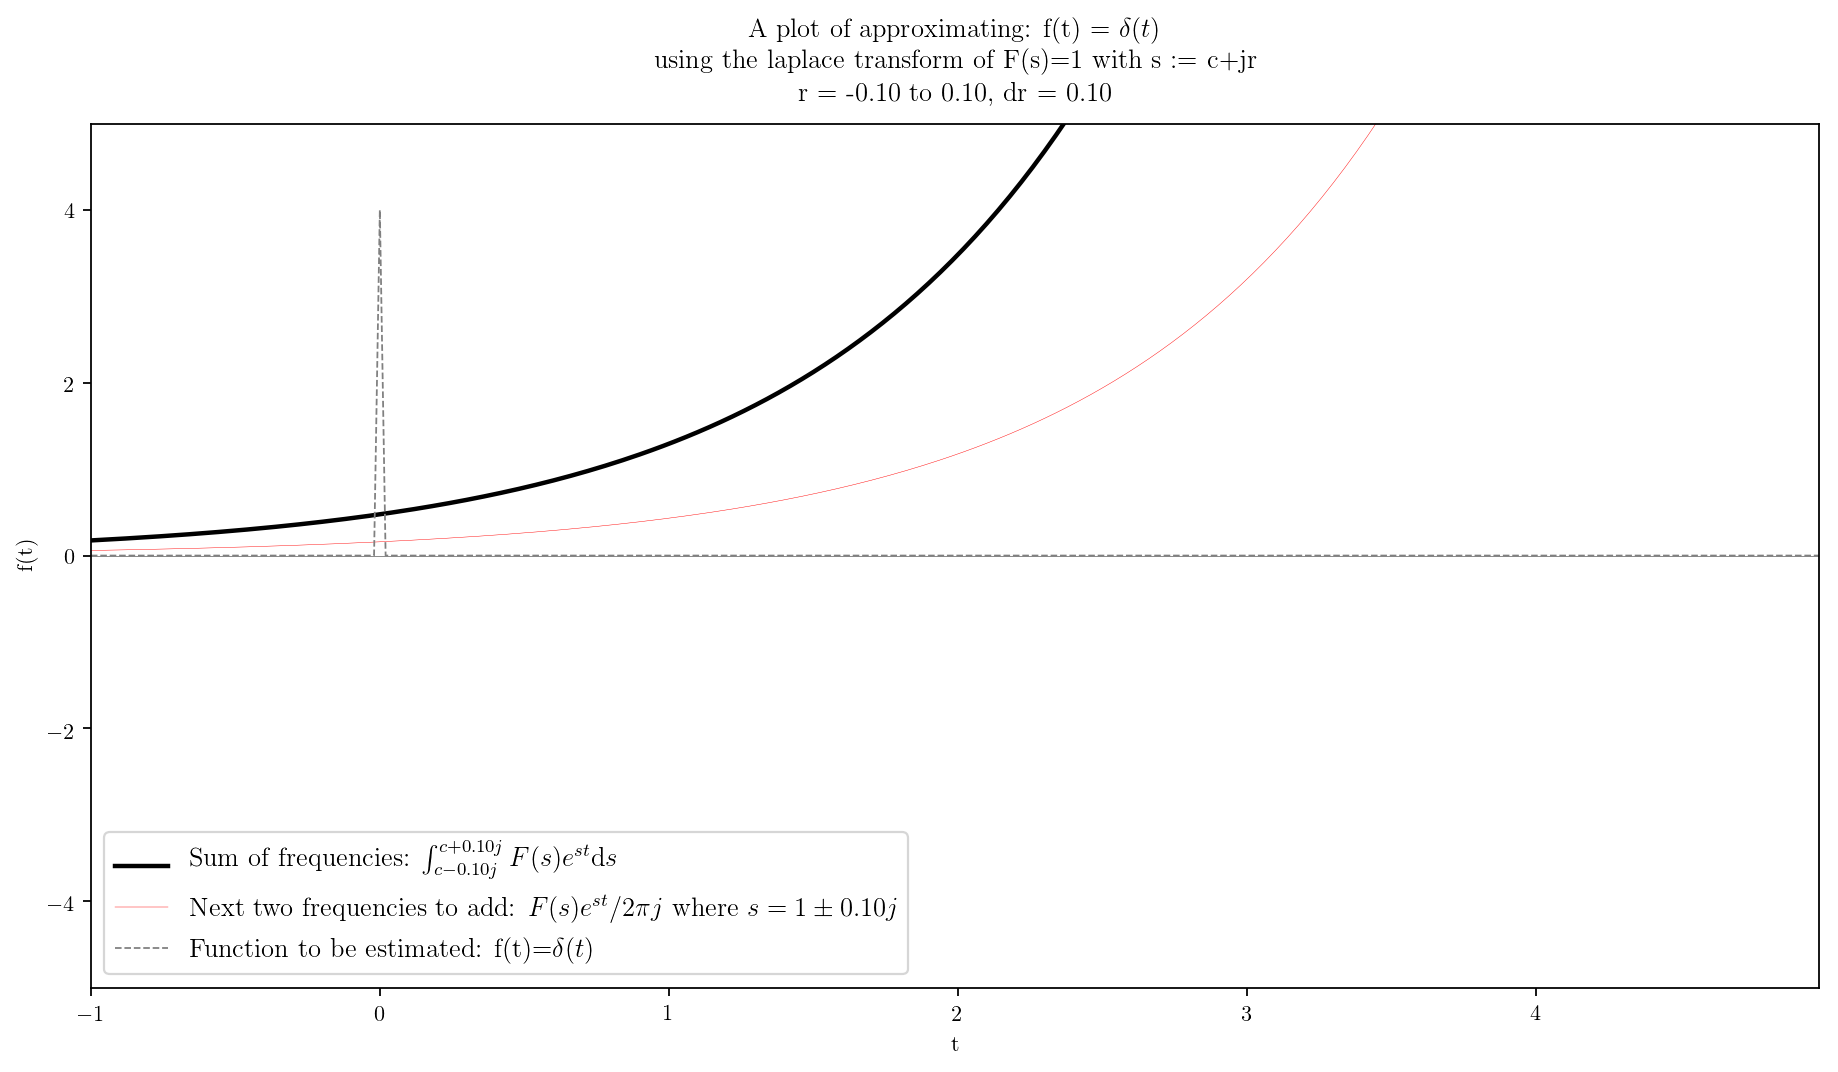

In [8]:
import numpy as np;
import matplotlib.pyplot as plt
from matplotlib import animation
from ipywidgets import IntProgress
from IPython.display import display

dpi=160
plt.rcParams["figure.figsize"] = (1920/dpi,1080/dpi)
plt.rcParams["figure.dpi"] = dpi
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

class Func1():
    def f(self,t):
        return np.array([1 if t_ > 0 else 0 for t_ in t])

    def F(self, s):  # The laplace transform of f(t)
        return 1/s
    F_asString = "1/s"
    f_asString = "1"
    c = 1  # Any value larger than the poles of s.  Which is s=0 in our case
    ylim = (-5,5)
    highestR = 200
    numFrames = 2000
    s_x_scale = 4
    dr_behaviour = "linear"
    
class Func_tCubic():
    def f(self, t):
        return np.array([-t_*t_*t_ + 4*t_*t_ - t_ - 4 if t_ > 0 else 0 for t_ in t])

    def F(self, s):  # The laplace transform of f(t)
        return -6/(s*s*s*s) + 8/(s*s*s) - 1/(s*s) - 4/s;
    F_asString = "$-6/s^4 + 8/s^3 - 1/s^2 - 4/s$"
    f_asString = "$-t^3+4t^2-t-4$"
    c = 1  # Any value larger than the poles of s.  Which is s=0 in our case
    ylim = (-5,5)
    highestR = 300
    numFrames = 1000
    s_x_scale = 4
    dr_behaviour = "squared"
    
class Func_cos():
    def f(self, t):
        return np.array([3*np.cos(10*t_) if t_ > 0 else 0 for t_ in t])

    def F(self, s):  # The laplace transform of f(t)
        return 3*s/(100+s*s);
    F_asString = "$(3 s)/(100 + s^2)$"
    f_asString = "$3\cos(10t)$"
    c = 1  # Any value larger than the poles of s.  Which has a real part at 0
    ylim = (-5,5)
    highestR = 500
    numFrames = 2000
    s_x_scale = 10
    dr_behaviour = "squared"

class Func_square_wave():
    # This is somewhat of a joke, because this has poles up to infinity, so it has no correct place to integrate
    A = 3 # height
    T = 1
    def f(self, t):
        return np.array([0 if t_ <= 0 else self.A if (t_ % self.T) < (self.T/2) else -self.A for t_ in t])
    def F(self, s):  # The laplace transform of f(t)
        return self.A/s * np.tanh(s*self.T/4);
    def __init__(self):
        self.f_asString = "Square wave, height: " + str(self.A) + ", period:" + str(self.T);
        self.F_asString = "$" + str(self.A) + "/s\cdot \mathrm{tanh}(" + str(self.T) +"s/4)$"
        self.c = self.T * 0.75  # Any value larger than the poles of s.  Which we don't have, so, uh, set to 1 and hope for the best
    ylim = (-5,5)
    highestR = 1000
    numFrames = 3000
    s_x_scale = 30
    dr_behaviour = "squared"
    
class Func_impulseAt0():
    def f(self, t):
        fuzz = 0.00000001 #Just for the sake of plotting
        return np.array([4 if t_ > -fuzz and t_ < fuzz else 0 for t_ in t])
    def F(self, s):  # The laplace transform of f(t)
        return 1;
    f_asString = "$\delta(t)$";
    F_asString = "$1$"
    c = 1  # Any value larger than the poles of s.  Which we don't have any of
    ylim = (-5,5)
    highestR = 1000
    numFrames = 10000
    s_x_scale = 30
    dr_behaviour = "constant"
    
func = Func_impulseAt0()

def F_r(r):
    s = (func.c+r*1j)
    return func.F(s)


def inverseAtR(r, t):
    s = (func.c+r*1j)
    e = 1/(2*np.pi) * np.exp(s*t)
    fs = func.F(s)
    return e * fs


def calculate(r, t):
    v = inverseAtR(r, t)
    if r != 0:
        v += inverseAtR(-r, t)
    return v.real

t = np.arange(-1, 5.0, 0.02)
plotcols = [(2, "black"),
            (0.2,"red"),
            (1, "green"), (1, "green")]
lines = []

def updateLegend(ax, r):
    global lines
    r = "%.2f" % r
    c = "%.0f" % func.c
    ax.legend(
        [lines[0], lines[1], lines[4]],
        [
        "Sum of frequencies: $\int^{c+" + r+ "j}_{c-" + r + "j} F(s)e^{st}\mathrm{d}s$",
        "Next two frequencies to add: $F(s)e^{st}/2\pi j$ where $s=" + c + "\pm" + r + "j$",
        "Function to be estimated: f(t)="+func.f_asString
        ], fontsize=12, loc='lower left')

def makePlot(fig):
    global lines
    lines = []
    ax = plt.axes(xlim=(np.min(t), np.max(t)), ylim=func.ylim)
    for index in range(len(plotcols)):
        lobj = ax.plot([],[],lw=plotcols[index][0],color=plotcols[index][1])[0]
        lines.append(lobj)
    ax.axhline(y=0, color='gray', lw=0.4)
    lines.append(ax.plot(t,func.f(t), '--', color='gray',lw=0.8)[0])
    updateLegend(ax, 0)
    margin=0.05
    fig.subplots_adjust(left=margin, bottom=margin, right=1-margin, top=0.85, wspace=None, hspace=None)
    plt.xlabel("t")
    plt.ylabel("f(t)")
    return ax

def getTitle(r):
    title = "A plot of approximating:     f(t) = " + func.f_asString + "\n"
    title += "using the laplace transform of F(s)=" + func.F_asString + " with s := c+jr\n"
    title += "r = -" + ("%.2f" % r) + " to " + ("%.2f" % r) + ", dr = " + ("%.2f" % r)
    return title

def single_plot(fig, r):
    global lines
    ax = makePlot(fig)
    fig.suptitle(getTitle(r), y=0.95)
    zero = calculate(0,t)
    updateLegend(ax, r)
    lines[0].set_data(t, zero + calculate(r,t))
    lines[1].set_data(t, zero)
    return ax

single_plot(plt.figure(), 0.1)
plt.show()

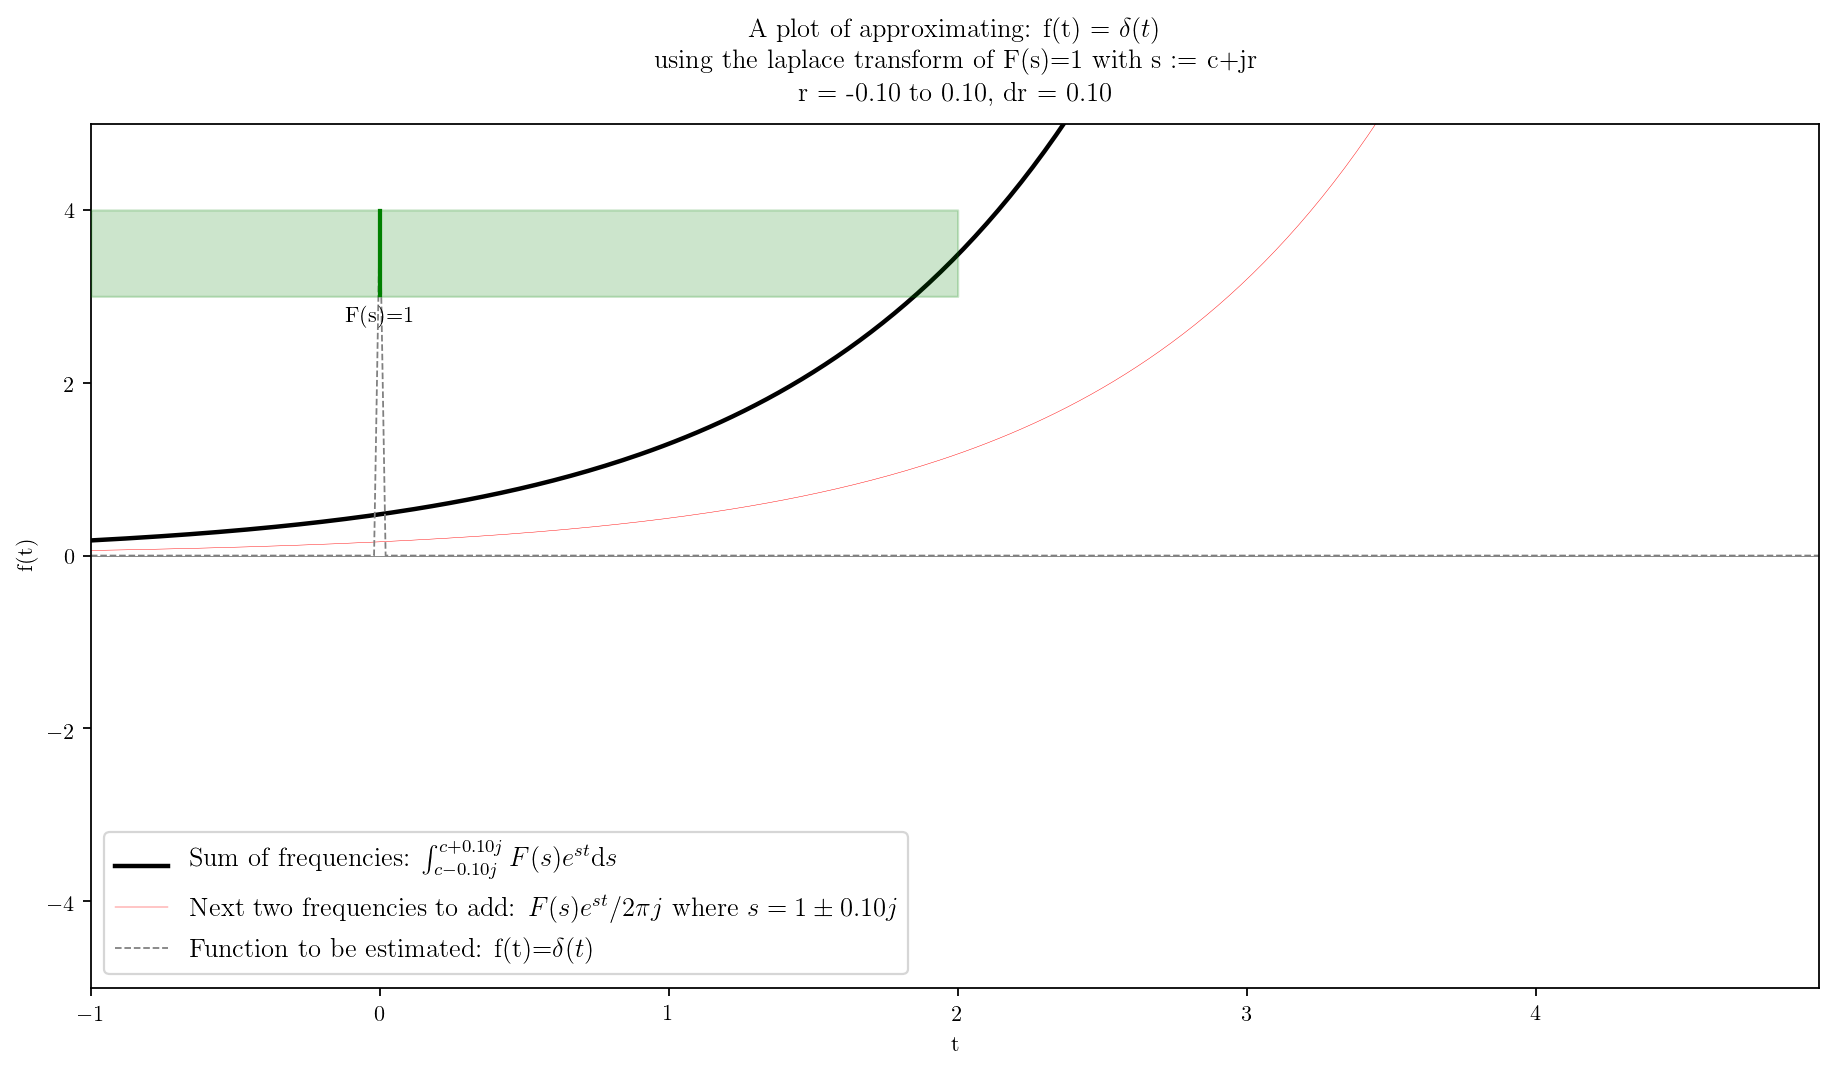

In [9]:
# Add functions to plot S in the top right hand corner
y_offset = 3
x_offset = 0
x_scale = func.s_x_scale

def graphOfS(ax):
    r = np.arange(-x_scale,2*x_scale,0.01)
    lines[2].set_zorder(101)
    lines[3].set_zorder(101)
    lobj = ax.fill_between(r/x_scale+x_offset,y_offset,y_offset+F_r(r).real,color="green",alpha=0.2, zorder=100)
    ax.text(0,y_offset-0.1,"F(s)=" + func.F_asString, horizontalalignment='center', verticalalignment='top')
    return lobj
def graphOfSLine(r):
    lines[2].set_data([r/x_scale+x_offset, r/x_scale+x_offset], [y_offset, y_offset + F_r(r).real])
    lines[3].set_data([-(r/x_scale+x_offset), -(r/x_scale+x_offset)], [y_offset, y_offset + F_r(r).real])
def single_plot_with_graph(fig, r):
    ax = single_plot(fig, r)
    lines.append(graphOfS(ax))
    updateLegend(ax, r)
    graphOfSLine(r)
single_plot_with_graph(plt.figure(), 0.1)
plt.show()

In [ ]:
# Now lets make an animation from this
lastData = []
lastR = 0

fig = plt.figure()
ax = makePlot(fig)
def initAnimation():
    global lastData, lastR, ax
    lines.append(graphOfS(ax))
    lastR = 0
    lastData = np.zeros(t.shape)
    return lines

def animate(i):
    global lastData, lastR, fig, progressBar
    dr = func.highestR/func.numFrames
    if func.dr_behaviour == "squared":
        dr *= (2 * i/func.numFrames) * (2 * i/func.numFrames)
    elif func.dr_behaviour == "linear":
        dr *= (2 * i/func.numFrames)
    r = lastR + dr
    fig.suptitle(getTitle(r), y=0.95)
    newData = calculate(r,t)
    lastData += newData * dr
    lastR = r
    updateLegend(ax, r)
    lines[0].set_data(t, lastData)
    lines[1].set_data(t, newData)
    graphOfSLine(r)
    progressBar.value = i
    return lines

progressBar = IntProgress(min=0, max=func.numFrames)
display(progressBar) # Show a progress bar, since this can take a while

anim = animation.FuncAnimation(fig, animate, init_func=initAnimation, frames=func.numFrames, interval=0, blit=True)
anim.save('laplace_animation.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
progressBar.visible = False

IntProgress(value=0, max=10000)